# Install dependencies

In [1]:
!pip install tensorflow-gpu==2.1
!pip install keras==2.3.0

     |████████████████████████████████| 421.8MB 42kB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 450kB 50.6MB/s 
     |████████████████████████████████| 3.9MB 56.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=afb73e9350f0c3385c502caff619d43b32d08d1e55ac02f4acc3a3936a406a15
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

# Connect google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
'20200828_020417[1].mp4'   CV_Kacper_Wachnik.pdf   im.png
'20200828_021938[1].mp4'   Digits_ocr		   Mister_car
'20200828_021938[2].mp4'   Draw_texts		  'SZKOŁA ŚREDNIA.jpg'
'Colab Notebooks'	   FIZYKA.jpg		   UdemyMachineLearningAZ


# Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from scipy import misc
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
import h5py

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Embedding, TimeDistributed, \
Conv2D, MaxPooling2D, GlobalMaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageDraw, ImageFont
from keras.datasets import mnist

import os
from os import path
import datetime
import random
from random import shuffle, randint
import glob
import shutil

import pickle
import gzip

Using TensorFlow backend.


# Useful commands

In [4]:
%pwd

'/content'

# Useful constants

In [5]:
working_dir = "working_dir/"

if not os.path.isdir(working_dir):
    os.mkdir(working_dir)

vocab = ['s', '0', '1', '2', '3', '4', '5', '6',
            '7', '8', '9', 'e']

ixtoword = {}
wordtoix = {}
ix = 0
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword)

# max length of the digit sequence
max_length = 6

# Useful functions

In [6]:
def grayscale_to_rgb(img, color_map=None):
    w, h, c = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0:1] = img
    ret[:, :, 1:2] = img
    ret[:, :, 2:3] = img
    if color_map is not None:
        buf = cv2.applyColorMap(ret, color_map)
        ret = buf
    return ret

def visualize_data(images, channels):
    for i in range(25):
        plt.subplot(5, 5, i+1)
        im = None
        if channels == 3:
            im = cv2.cvtColor(images[i+1], cv2.COLOR_BGR2RGB)
            plt.imshow(im.reshape(25,50,3), cmap='gray')
        else:
            im = images[i+1]
            plt.imshow(im.reshape(25,50), cmap='gray')
        plt.axis('off')

def encode_sequence(img, string, wordtoix):
    images, in_sequences, out_sequences = list(), list(), list()
    # encode the sequence
    seq = [wordtoix[char] for char in string if char in wordtoix]
    seq.insert(0, 0)
    seq.append(11)
    # split one sequence into multiple X, y pairs
    for i in range(1, len(seq)):
    # split into input and output pair
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        images.append(np.asarray(img))
        in_sequences.append(in_seq)
        out_sequences.append(out_seq)
    return np.array(images), np.array(in_sequences), np.array(out_sequences)

def normalize_data(img_data):
    #Converting everything to floats
    img_data = img_data.astype('float32')
    #Normalizing values between 0 and 1
    img_data /= 255
    return img_data

# Load synthetic data using different fonts

In [7]:
!7za x /mydrive/Digits_ocr/fonts.7z -oworking_dir


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /mydrive/Digits_ocr/                              1 file, 54649388 bytes (53 MiB)

Extracting archive: /mydrive/Digits_ocr/fonts.7z
--
Path = /mydrive/Digits_ocr/fonts.7z
Type = 7z
Physical Size = 54649388
Headers Size = 4936
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      5% 15 - fonts/ariblk.ttf                           10% 53 - fonts/calibrili.ttf                              19% 91 - fonts/COPRGTL.TTF                            26% 125 - fonts/FRAHV.TTF                          

(32750, 25, 50, 1)
(32750, 6)
(32750, 12)


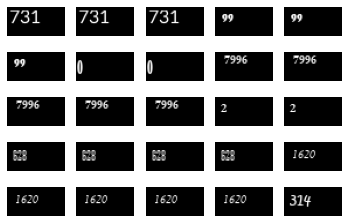

In [24]:
# random.seed(42)

SAMPLES = 10000
fonts_path = working_dir + "fonts"

def load_synthetic_data_from_fonts(samples, fonts_path, channels):

    X1_synt, X2_synt, y_synt = list(), list(), list()
    fonts_files = os.listdir(fonts_path)
    fonts_files_num = len(fonts_files)

    for s in range(samples):
        img = None
        
        # random font
        font_file = random.randint(0, fonts_files_num-1)
        font_size = random.randint(10, 16)
        fnt = ImageFont.truetype('{}/{}'.format(fonts_path, fonts_files[font_file]), font_size)

        # number of digits in number
        digits = randint(1,int(50/font_size))

        # concatenate digits into number
        number = ""
        for j in range(digits):
            dgt = random.randint(0, 9)
            number += str(dgt)

        if channels == 3:
            R, G, B = random.randint(0, 30), random.randint(0, 30), random.randint(0, 30)
            img = Image.new('RGB', (50, 25), color = (R, G, B))
        elif channels == 1:
            grayscale_value = random.randint(0, 30)
            img = Image.new('L', (50, 25), color = grayscale_value)
        else:
            raise Exception("Incorrect number of channels (should be either 1 or 3)")

        # draw number
        start_x, start_y = random.randint(16-font_size, 18-font_size), random.randint(2, 4)
        d = ImageDraw.Draw(img)

        if channels == 3:
            R, G, B = random.randint(150, 255), random.randint(150, 255), random.randint(150, 255)
            d.text((start_x, start_y), number, font=fnt, fill=(R, G, B))
        else:
            grayscale_value = random.randint(150, 255)
            d.text((start_x, start_y), number, font=fnt, fill=grayscale_value)

        img_array, in_seq, out_seq = encode_sequence(img, number, wordtoix)
        X1_synt.extend(img_array)
        X2_synt.extend(in_seq)
        y_synt.extend(out_seq)

    X1_synt = np.array(X1_synt)
    X2_synt = np.array(X2_synt)
    y_synt = np.array(y_synt)

    if channels == 1:
        X1_synt = np.expand_dims(X1_synt, axis = 3)

    return X1_synt, X2_synt, y_synt

channels = 1
X1_synt_fonts, X2_synt_fonts, y_synt_fonts = load_synthetic_data_from_fonts(SAMPLES, fonts_path, 
                                                                            channels)
print(X1_synt_fonts.shape)
print(X2_synt_fonts.shape)
print(y_synt_fonts.shape)

# normalize the data
X1_synt_fonts = normalize_data(X1_synt_fonts)

# Visualize digits sequences generated
visualize_data(X1_synt_fonts, channels)

# Load synthetic data using MNIST digits

(39898, 25, 50, 1)
(39898, 6)
(39898, 12)


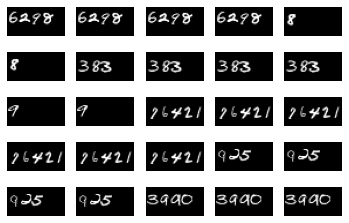

In [25]:
# random.seed(42)

def load_synthetic_data_from_mnist(samples, channels):

    X1_synt, X2_synt, y_synt = list(), list(), list()

    # Load raw data from keras dataset
    (X_raw, y_raw), (X_raw_test, y_raw_test) = mnist.load_data()
    n_train, n_test = X_raw.shape[0], X_raw_test.shape[0]
    n_class, n_len, height, width = 11, 5, 25, 10

    X_len = X_raw.shape[0]

    for j in range(samples):
        # generate random numbers of digits
        img = np.zeros((height, width*n_len), dtype=np.uint8)
        n_digit = random.randint(1,5)
        number = ""
        shift_vert = random.randint(4, 12)
        for i in range(n_digit):
            index = random.randint(0, X_len-1)
            image = X_raw[index]
            image = image[3:28, 4:24]
            # resize image
            image = cv2.resize(image, (10,12))
            shift_hor = random.randint(0, 2) if i != 4 else 0
            img[shift_vert:shift_vert+12, 
                shift_hor+i*width:shift_hor+width+i*width] = image.copy()
            number += str(y_raw[index])

        # convert from grayscale (1 channel) to RGB (3 channels)
        if channels == 3:
            img = np.expand_dims(img, axis = 2)
            color_map = random.randint(0, 11)
            img = grayscale_to_rgb(img, color_map)
        elif channels != 1:
            raise Exception("Incorrect number of channels (should be either 1 or 3)")

        img_array, in_seq, out_seq = encode_sequence(img, number, wordtoix)
        X1_synt.extend(img_array)
        X2_synt.extend(in_seq)
        y_synt.extend(out_seq)

    X1_synt = np.array(X1_synt)
    X2_synt = np.array(X2_synt)
    y_synt = np.array(y_synt)

    if channels == 1:
        X1_synt = np.expand_dims(X1_synt, axis = 3)

    return X1_synt, X2_synt, y_synt

channels = 1
X1_synt_mnist, X2_synt_mnist, y_synt_mnist = load_synthetic_data_from_mnist(int(SAMPLES), 
                                                                            channels)
print(X1_synt_mnist.shape)
print(X2_synt_mnist.shape)
print(y_synt_mnist.shape)

# normalize the data
X1_synt_mnist = normalize_data(X1_synt_mnist)

# Visualize digits sequences generated
visualize_data(X1_synt_mnist, channels)

# Load real, custom data

In [10]:
!7za x /mydrive/Digits_ocr/custom_digits_sequences.7z -oworking_dir


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /mydrive/Digits_ocr/                              1 file, 226711 bytes (222 KiB)

Extracting archive: /mydrive/Digits_ocr/custom_digits_sequences.7z
--
Path = /mydrive/Digits_ocr/custom_digits_sequences.7z
Type = 7z
Physical Size = 226711
Headers Size = 6429
Method = LZMA2:19
Solid = +
Blocks = 1

  0%    Everything is Ok

Folders: 173
Files: 306
Size:       422733
Compressed: 226711


(997, 25, 50, 1)
(997, 6)
(997, 12)


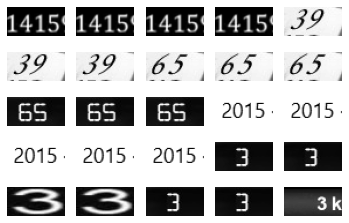

In [26]:
# random.seed(42)

def load_real_data(channels):

    X1_real, X2_real, y_real = list(), list(), list()
    training_folders = os.listdir(working_dir + 'custom_digits_sequences')

    for f in training_folders:
        training_files = os.listdir(working_dir + 'custom_digits_sequences/' + f)
        for image in training_files:
            path = working_dir + 'custom_digits_sequences/' + f + '/' + image
            im = None

            if channels == 3:
                im = cv2.imread(path, cv2.IMREAD_COLOR)
            elif channels == 1:
                im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            else:
                raise Exception("Incorrect number of channels (should be either 1 or 3)")

            img_array, in_seq, out_seq = encode_sequence(im, f, wordtoix)
            X1_real.extend(img_array)
            X2_real.extend(in_seq)
            y_real.extend(out_seq)

    X1_real = np.array(X1_real)
    X2_real = np.array(X2_real)
    y_real = np.array(y_real)

    if channels == 1:
        X1_real = np.expand_dims(X1_real, axis = 3)

    return X1_real, X2_real, y_real

channels = 1
X1_real, X2_real, y_real = load_real_data(channels)
print(X1_real.shape)
print(X2_real.shape)
print(y_real.shape)

# normalize the data
X1_real = normalize_data(X1_real)

# Visualize digits sequences generated
visualize_data(X1_real, channels)

# Model building

In [20]:
def get_model(channels):
    # input image
    inputs_img = tf.keras.Input(shape=(25, 50, channels))

    # convolution model
    x = Conv2D(32, kernel_size=(3, 3), strides=2, 
            padding='valid', activation='relu')(inputs_img)
    x = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), 
                    padding='valid', data_format=None)(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=1, 
            padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), 
                    padding='valid', data_format=None)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=1, 
            padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), 
                    padding='valid', data_format=None)(x)

    # fully connected
    x = Flatten()(x)
    fe1 = Dropout(0.5)(x)
    fe2 = Dense(128, activation='relu')(fe1)

    # partial caption sequence model
    vocab_size = 12
    max_length = 6
    embedding_dim = 50

    inputs_seq = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim)(inputs_seq) #, mask_zero=True
    mask = tf.keras.layers.Masking(mask_value=0)(se1)
    se2 = Dropout(0.5)(mask)
    se3 = LSTM(64)(se2)

    # decoder (feed forward) model
    decoder1 = tf.keras.layers.concatenate([fe2, se3])
    decoder2 = Dense(64, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # merge the two input models
    model = Model(inputs=[inputs_img, inputs_seq], outputs=outputs)

    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['accuracy'])
    
    return model

channels = 1
model = get_model(channels)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 25, 50, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 12, 24, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 10, 22, 32)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 8, 20, 64)    18496       max_pooling2d_9[0][0]            
____________________________________________________________________________________________

# Visualize the network model using graphviz

In [ ]:
from tensorflow.keras.utils import plot_model, model_to_dot
from IPython.display import Image, SVG
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

# Setup TensorBoard before training

In [ ]:
%load_ext tensorboard
%tensorboard --logdir working_dir/logs/fit

# Train

In [27]:
#random.seed(42)

# Load the data and print its shape
X1 = np.concatenate((X1_synt_fonts, X1_synt_mnist, X1_real), axis=0) #, X1_real
X2 = np.concatenate((X2_synt_fonts, X2_synt_mnist, X2_real), axis=0) #, X2_real
y = np.concatenate((y_synt_fonts, y_synt_mnist, y_real), axis=0) #, y_real
print(X1.shape)
print(X2.shape)
print(y.shape)

# Load existing weights
# model.load_weights('/mydrive/Digits_ocr/model3.h5')

# TensorBoard settings
log_dir = working_dir + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

# Train the neural network.
model.fit(
		x=[X1, X2], y=y,
        epochs=20,
		shuffle=True,
		#validation_data=([X1_real, X2_real], y_real),
        validation_split=0.2,
		#callbacks=[tensorboard_callback]
          )

(73645, 25, 50, 1)
(73645, 6)
(73645, 12)
Train on 58916 samples, validate on 14729 samples
Epoch 1/20
58916/58916 [==============================] - 14s 243us/sample - loss: 0.5816 - accuracy: 0.8271 - val_loss: 0.6629 - val_accuracy: 0.8224
Epoch 2/20
58916/58916 [==============================] - 14s 244us/sample - loss: 0.4537 - accuracy: 0.8588 - val_loss: 0.6079 - val_accuracy: 0.8434
Epoch 3/20
58916/58916 [==============================] - 14s 242us/sample - loss: 0.4231 - accuracy: 0.8674 - val_loss: 0.6319 - val_accuracy: 0.8356
Epoch 4/20
58916/58916 [==============================] - 14s 244us/sample - loss: 0.4016 - accuracy: 0.8725 - val_loss: 0.6001 - val_accuracy: 0.8401
Epoch 5/20
58916/58916 [==============================] - 14s 244us/sample - loss: 0.3809 - accuracy: 0.8797 - val_loss: 0.5759 - val_accuracy: 0.8449
Epoch 6/20
58916/58916 [==============================] - 14s 246us/sample - loss: 0.3747 - accuracy: 0.8806 - val_loss: 0.6125 - val_accuracy: 0.8395
Ep

# Save the model

In [28]:
model.save_weights('/mydrive/Digits_ocr/model.h5')

# Predict

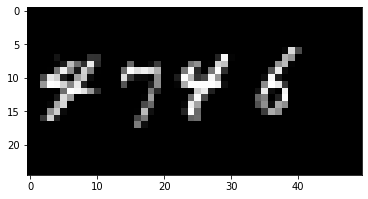

Greedy: 4 7 4 6


In [35]:
def greedySearch(photo):
    in_text = 's'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += '' + word
        if word == 'e':
            break
    final = in_text
    final = final[1:-1]
    final = ' '.join(final)
    return final

# check on synthetic data
image = X1_synt_mnist[300]
plt.imshow(image.reshape(25,50), cmap='gray')
plt.show()

imageCopy = image.copy()
imageCopy *= 255
if not cv2.imwrite('/mydrive/im.png', np.float32(imageCopy)):
    raise Exception("Could not write image")

# prepare for the inference
image = image.reshape(-1, 25, 50, 1)

if image is not None:
    print("Greedy:", greedySearch(image))
else:
    print('Image is None')